# Analysis of snaps from 20170810-14 

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0, '../../')
import mwc_growth as mwc
import glob 
import pandas as pd
from tqdm import tqdm_notebook as tqdmn

import bokeh.io
import bokeh.plotting
import skimage.io
import skimage.exposure
import skimage.measure
import skimage.morphology
import scipy.ndimage

mwc.set_plotting_style()
%matplotlib inline

In [41]:
import imp
imp.reload(mwc)

<module 'mwc_growth' from '../../mwc_growth.py'>

In [55]:
# Glob all of the images with aTc. 
data_dir = '20170810/'
snap_files = glob.glob("{0}*CFP*.TIF".format(data_dir))
concs = np.unique([_file.split('_')[-3] for _file in snap_files])
lam = np.unique([_file.split('_')[-2] for _file in snap_files])
concs
snap_files[0].split('_')[-3]

'00ngmL'

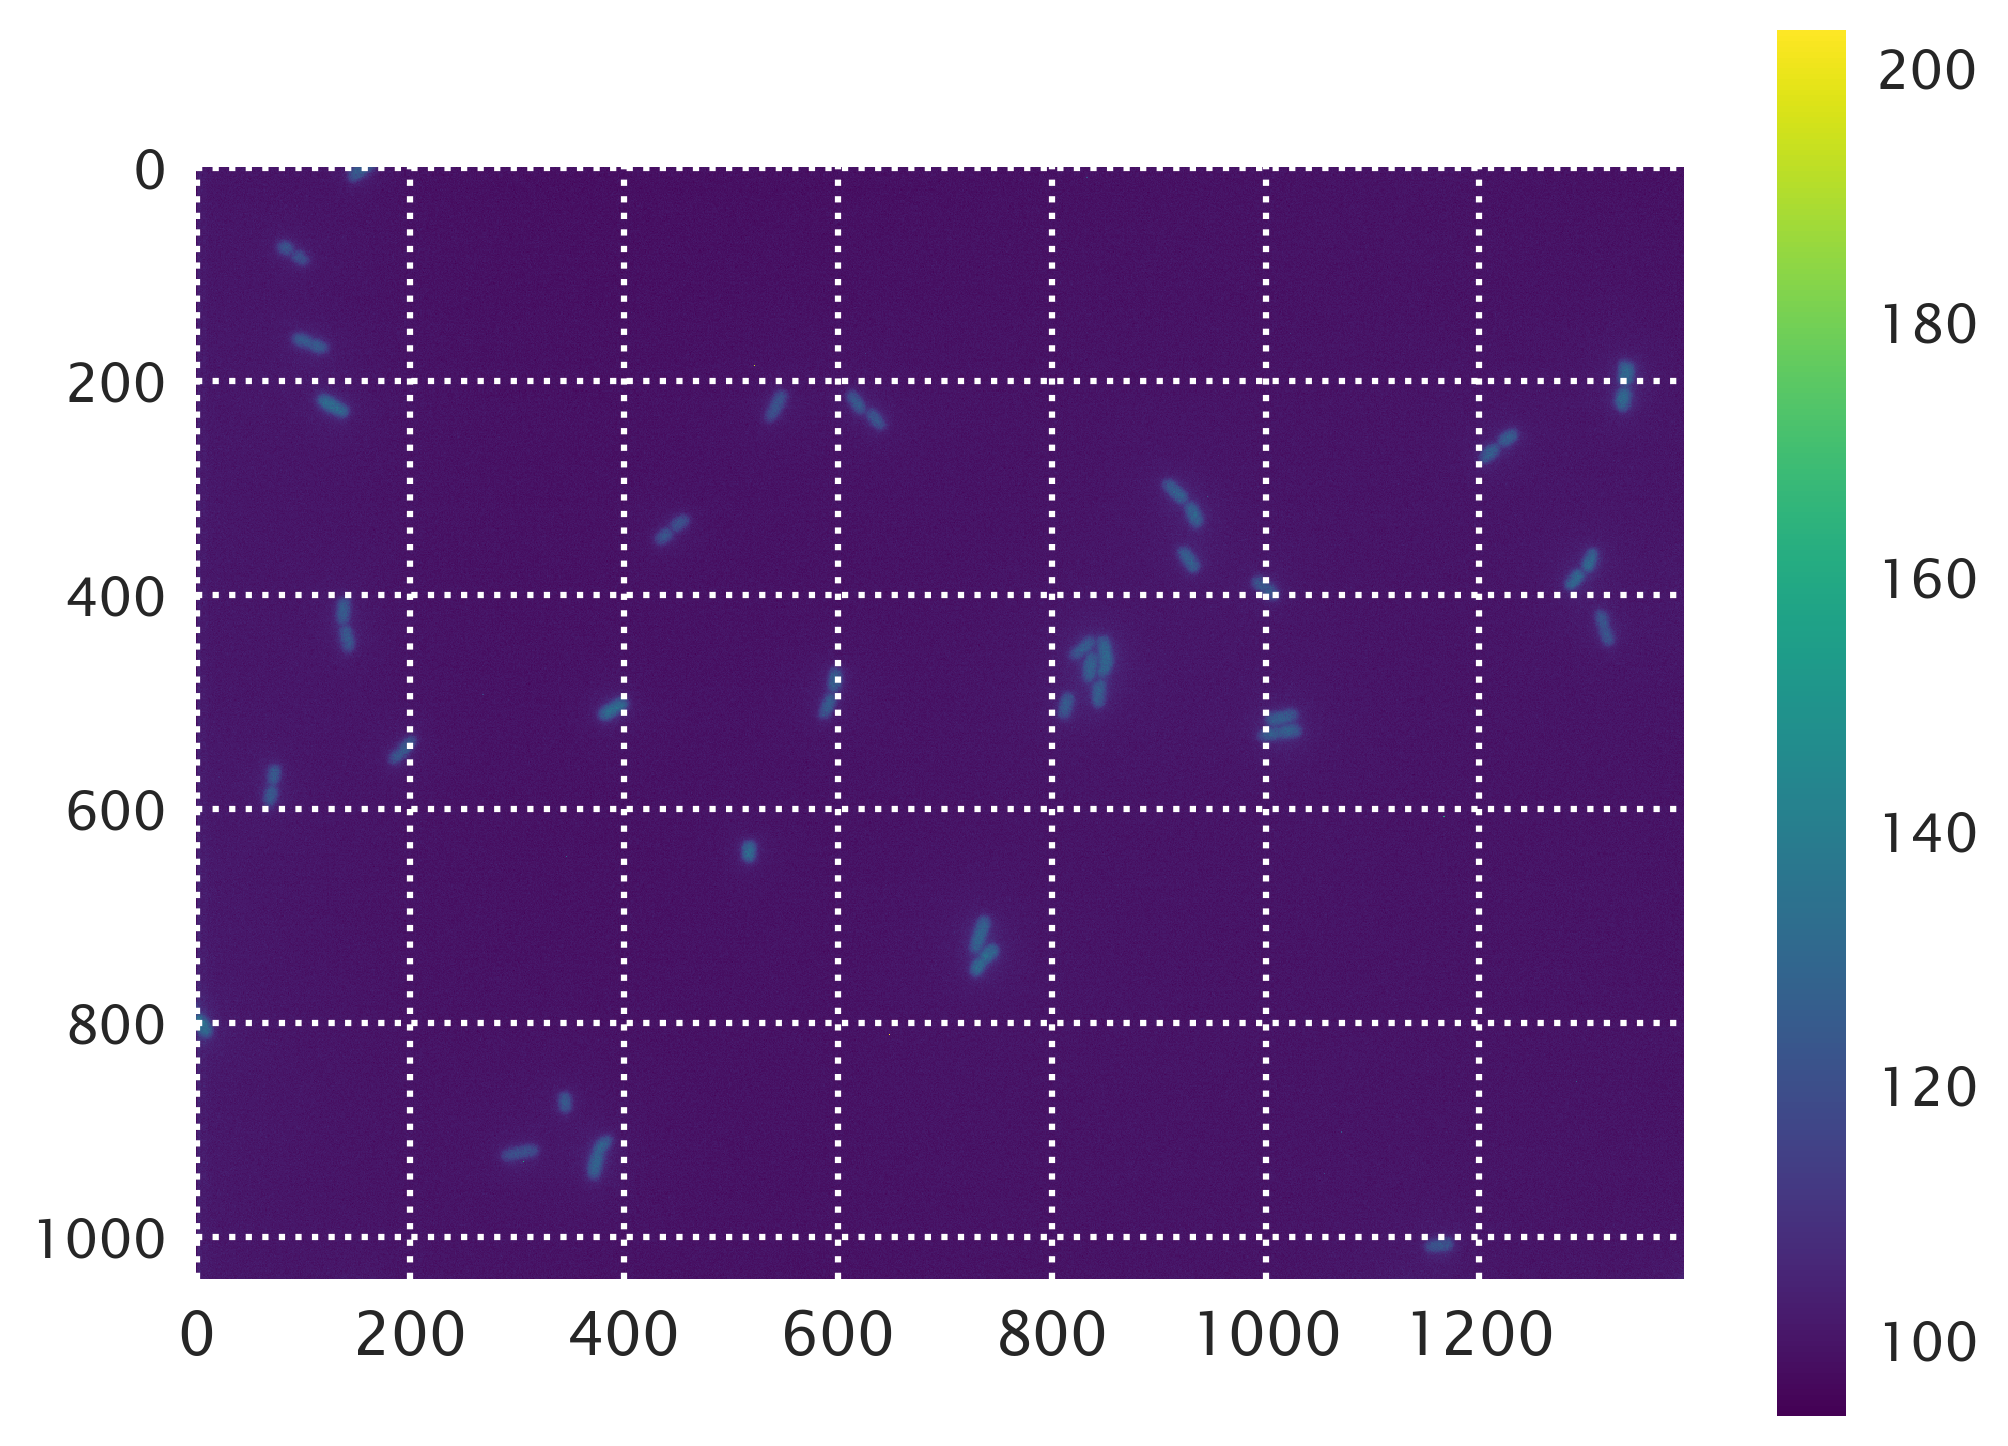

In [43]:
# load an example image and display. 
cfp_im = skimage.io.imread(snap_files[-1])
plt.imshow(cfp_im, cmap='viridis')
plt.colorbar()

../../mwc_growth.py:1244: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if selem == 'default':


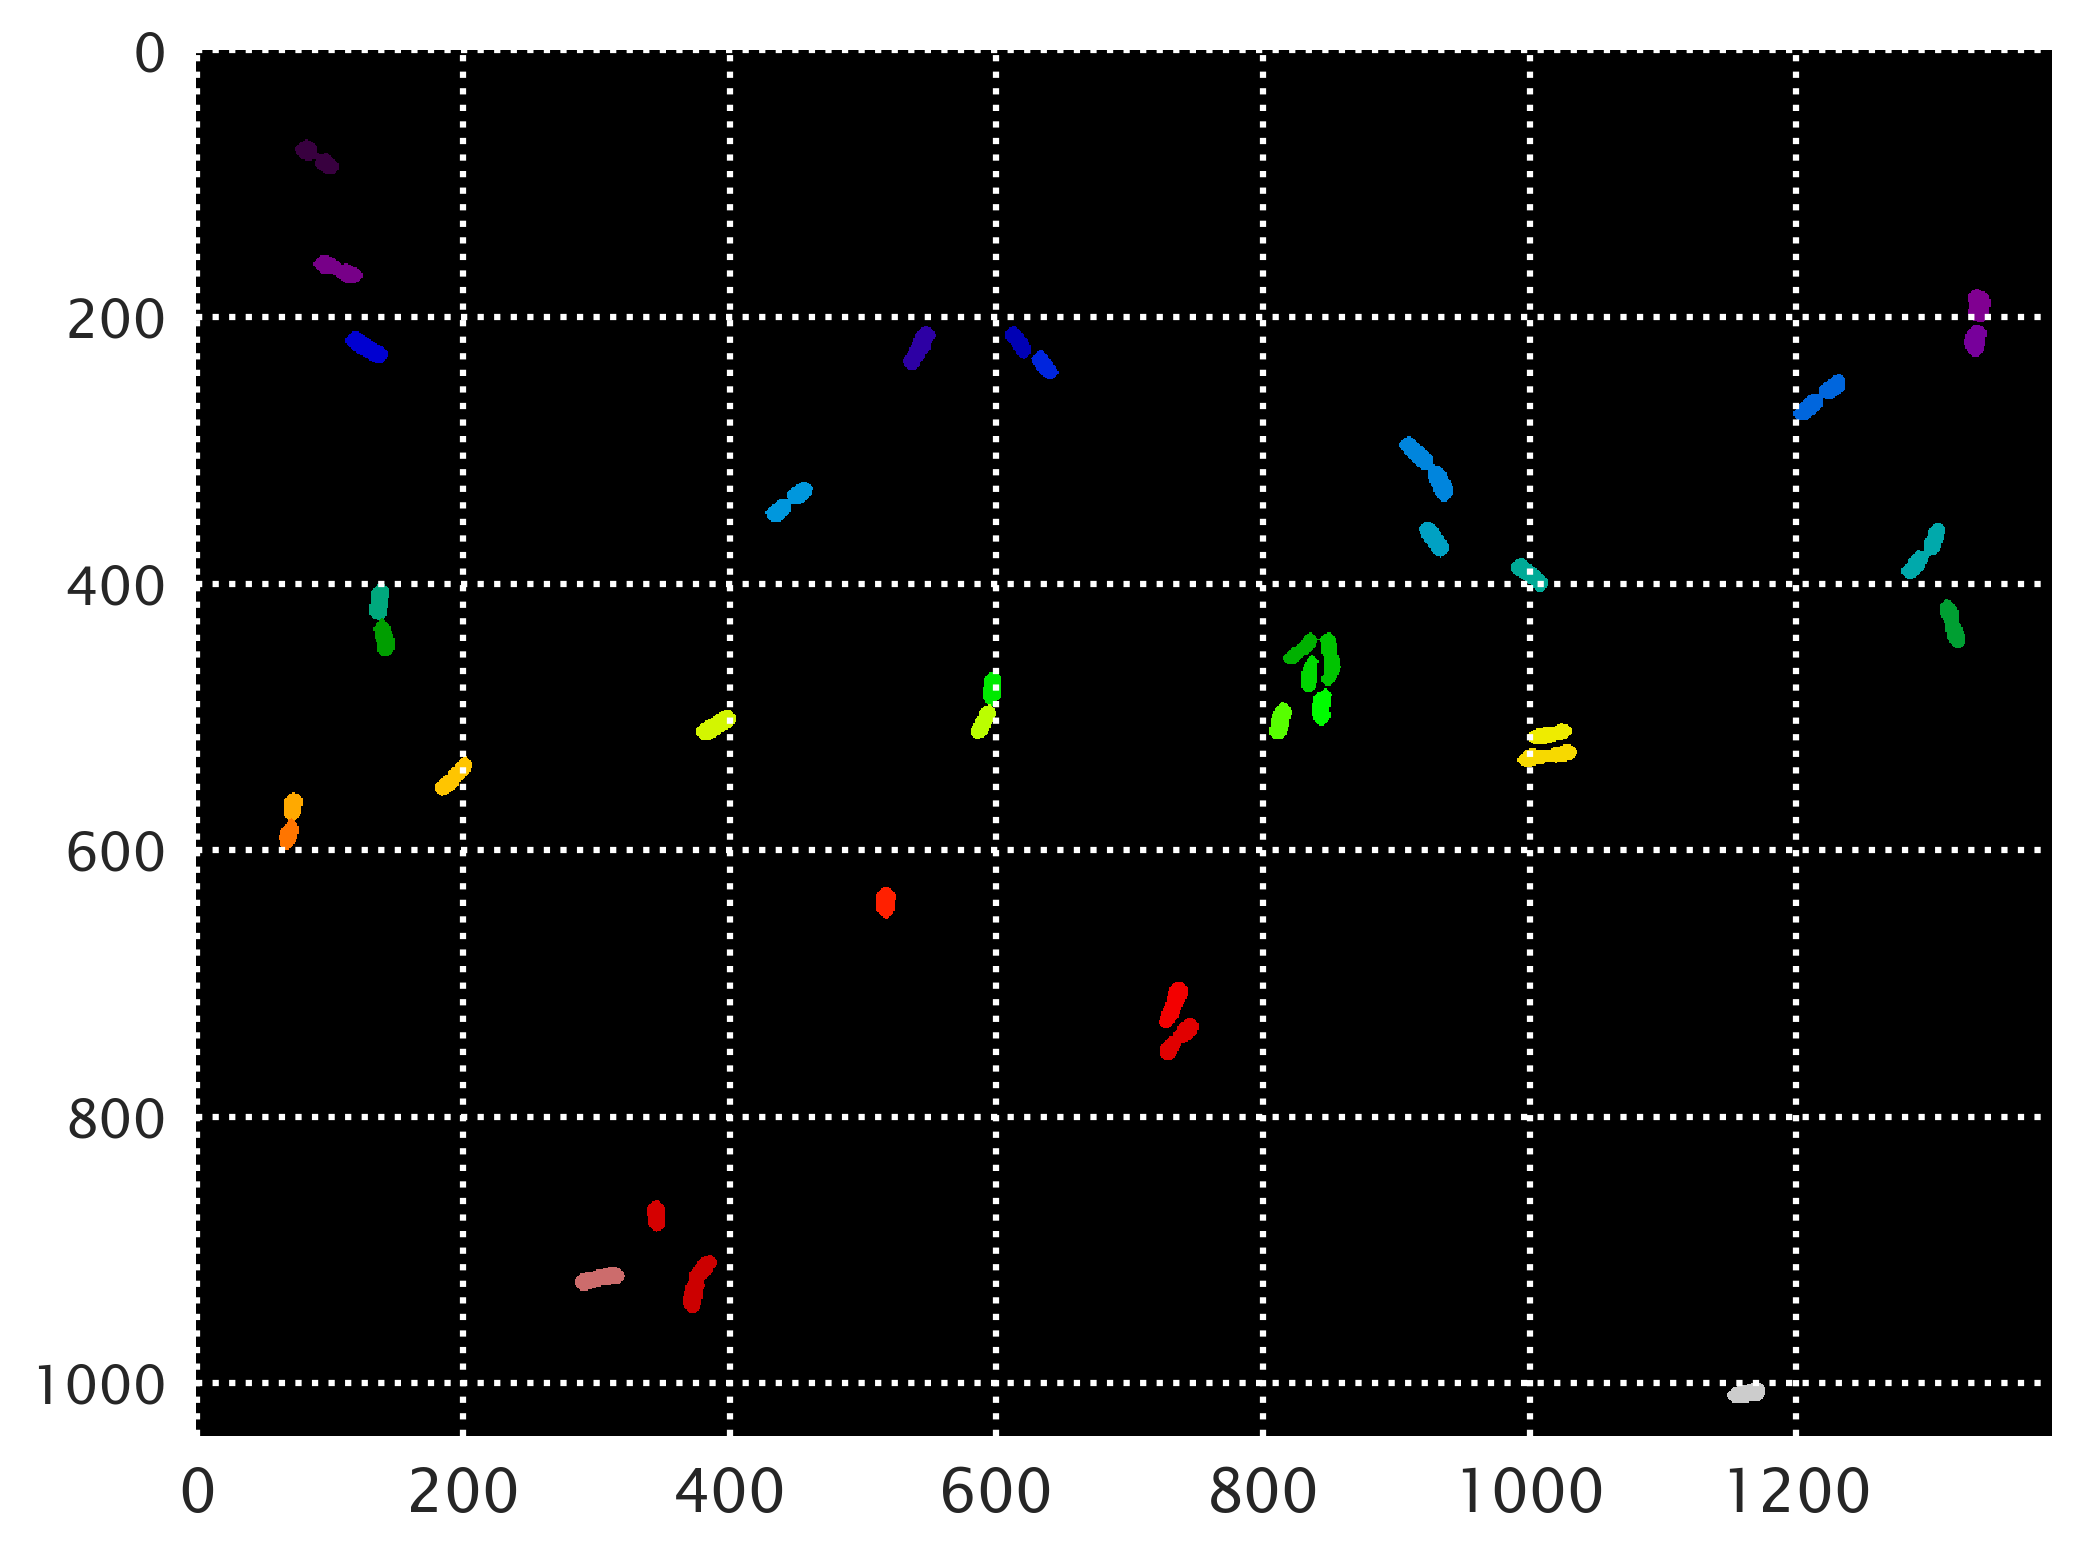

In [44]:
# Try segmenting using log. 
selem = skimage.morphology.square(3)
im_seg = mwc.log_segmentation(cfp_im, selem=selem, radius=2, thresh=1E-6, label=True)

def morph_suite(im_seg, its=1):
    im_seg = im_seg > 0
    im_seg = skimage.morphology.remove_small_objects(im_seg, min_size=200)
    erode = scipy.ndimage.binary_erosion(im_seg, iterations=its)
    lab = skimage.measure.label(erode)
    for i in range(its):
        if i==0:
            im_dil = skimage.morphology.dilation(lab)
        else:
            im_dil = skimage.morphology.dilation(im_dil)
            
    return im_dil
im_seg = morph_suite(im_seg, its=3)
plt.imshow(im_seg, cmap='nipy_spectral')

In [63]:
# Process all images and generate a single DataFrame. 
cols = ['date', 'operator', 'strain', 'atc_ngml', 'area', 'mean_mcherry', 'mean_yfp', 'mean_cfp']
dfs = []
dates = ['20170810', '20170814']
OPERATOR = 'O2'
med_selem = skimage.morphology.square(3)
ip_dist = 0.063  # in units of µm per pixel
for _, d in tqdmn(enumerate(dates), desc='processing dates'):
    snap_files = glob.glob("{0}/*CFP*.TIF".format(d))
    concs = np.unique([_file.split('_')[-3] for _file in snap_files])
    for i, conc in tqdmn(enumerate(concs), desc='processing strains'):
        
        if conc[-2:].lower() == 'ml':
            strain = 'dilution'
            atc_conc = int(conc[:-4])
        else:
            strain = conc
            atc_conc = 0
        cfp_files = glob.glob("{0}/*{1}*Brightfield*.TIF".format(d, conc))
        mch_files = glob.glob("{0}/*{1}*mCherry*.TIF".format(d, conc))
        yfp_files = glob.glob("{0}/*{1}*YFP*.TIF".format(d, conc))

        # Load all of the images. 
        cfp_ims = skimage.io.ImageCollection(cfp_files, conserve_memory=False)
        mch_ims = skimage.io.ImageCollection(mch_files, conserve_memory=False)
        yfp_ims = skimage.io.ImageCollection(yfp_files, conserve_memory=False)

        # Apply a median filter to the quantitative channels.  
        mch_ims = [scipy.ndimage.median_filter(m, footprint=med_selem) for m in mch_ims]
        yfp_ims = [scipy.ndimage.median_filter(y, footprint=med_selem) for y in yfp_ims]
        # Loop through each image and extract the information. 
        for j, im in enumerate(cfp_ims):
            seg = mwc.log_segmentation(im, selem=selem, radius=2, thresh=1E-6, label=False)
            seg = morph_suite(seg)

            # Compute the properties
            c_filt = scipy.ndimage.median_filter(im, footprint=med_selem)
            c_props = skimage.measure.regionprops(seg, c_filt)
            y_props = skimage.measure.regionprops(seg, yfp_ims[j])
            m_props = skimage.measure.regionprops(seg, mch_ims[j])
            area = [prop.area * ip_dist**2 for prop in c_props]
            c_ints = [prop.mean_intensity for prop in c_props]
            y_ints = [prop.mean_intensity for prop in y_props]
            m_ints = [prop.mean_intensity for prop in m_props]

            # Add to the dataFrame
            _ = pd.DataFrame({'date' : d, 'operator' : OPERATOR, 'strain':strain,  
                             'atc_ngml': atc_conc, 'area': area, 'mean_mcherry': m_ints,
                             'mean_yfp': y_ints, 'mean_cfp': c_ints})
            dfs.append(_)
df = pd.concat(dfs, axis=0, ignore_index=True)

../../mwc_growth.py:1244: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if selem == 'default':


/Users/gchure/anaconda/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


In [64]:
snap_files[0].split('_')[-3]

'00ngml'

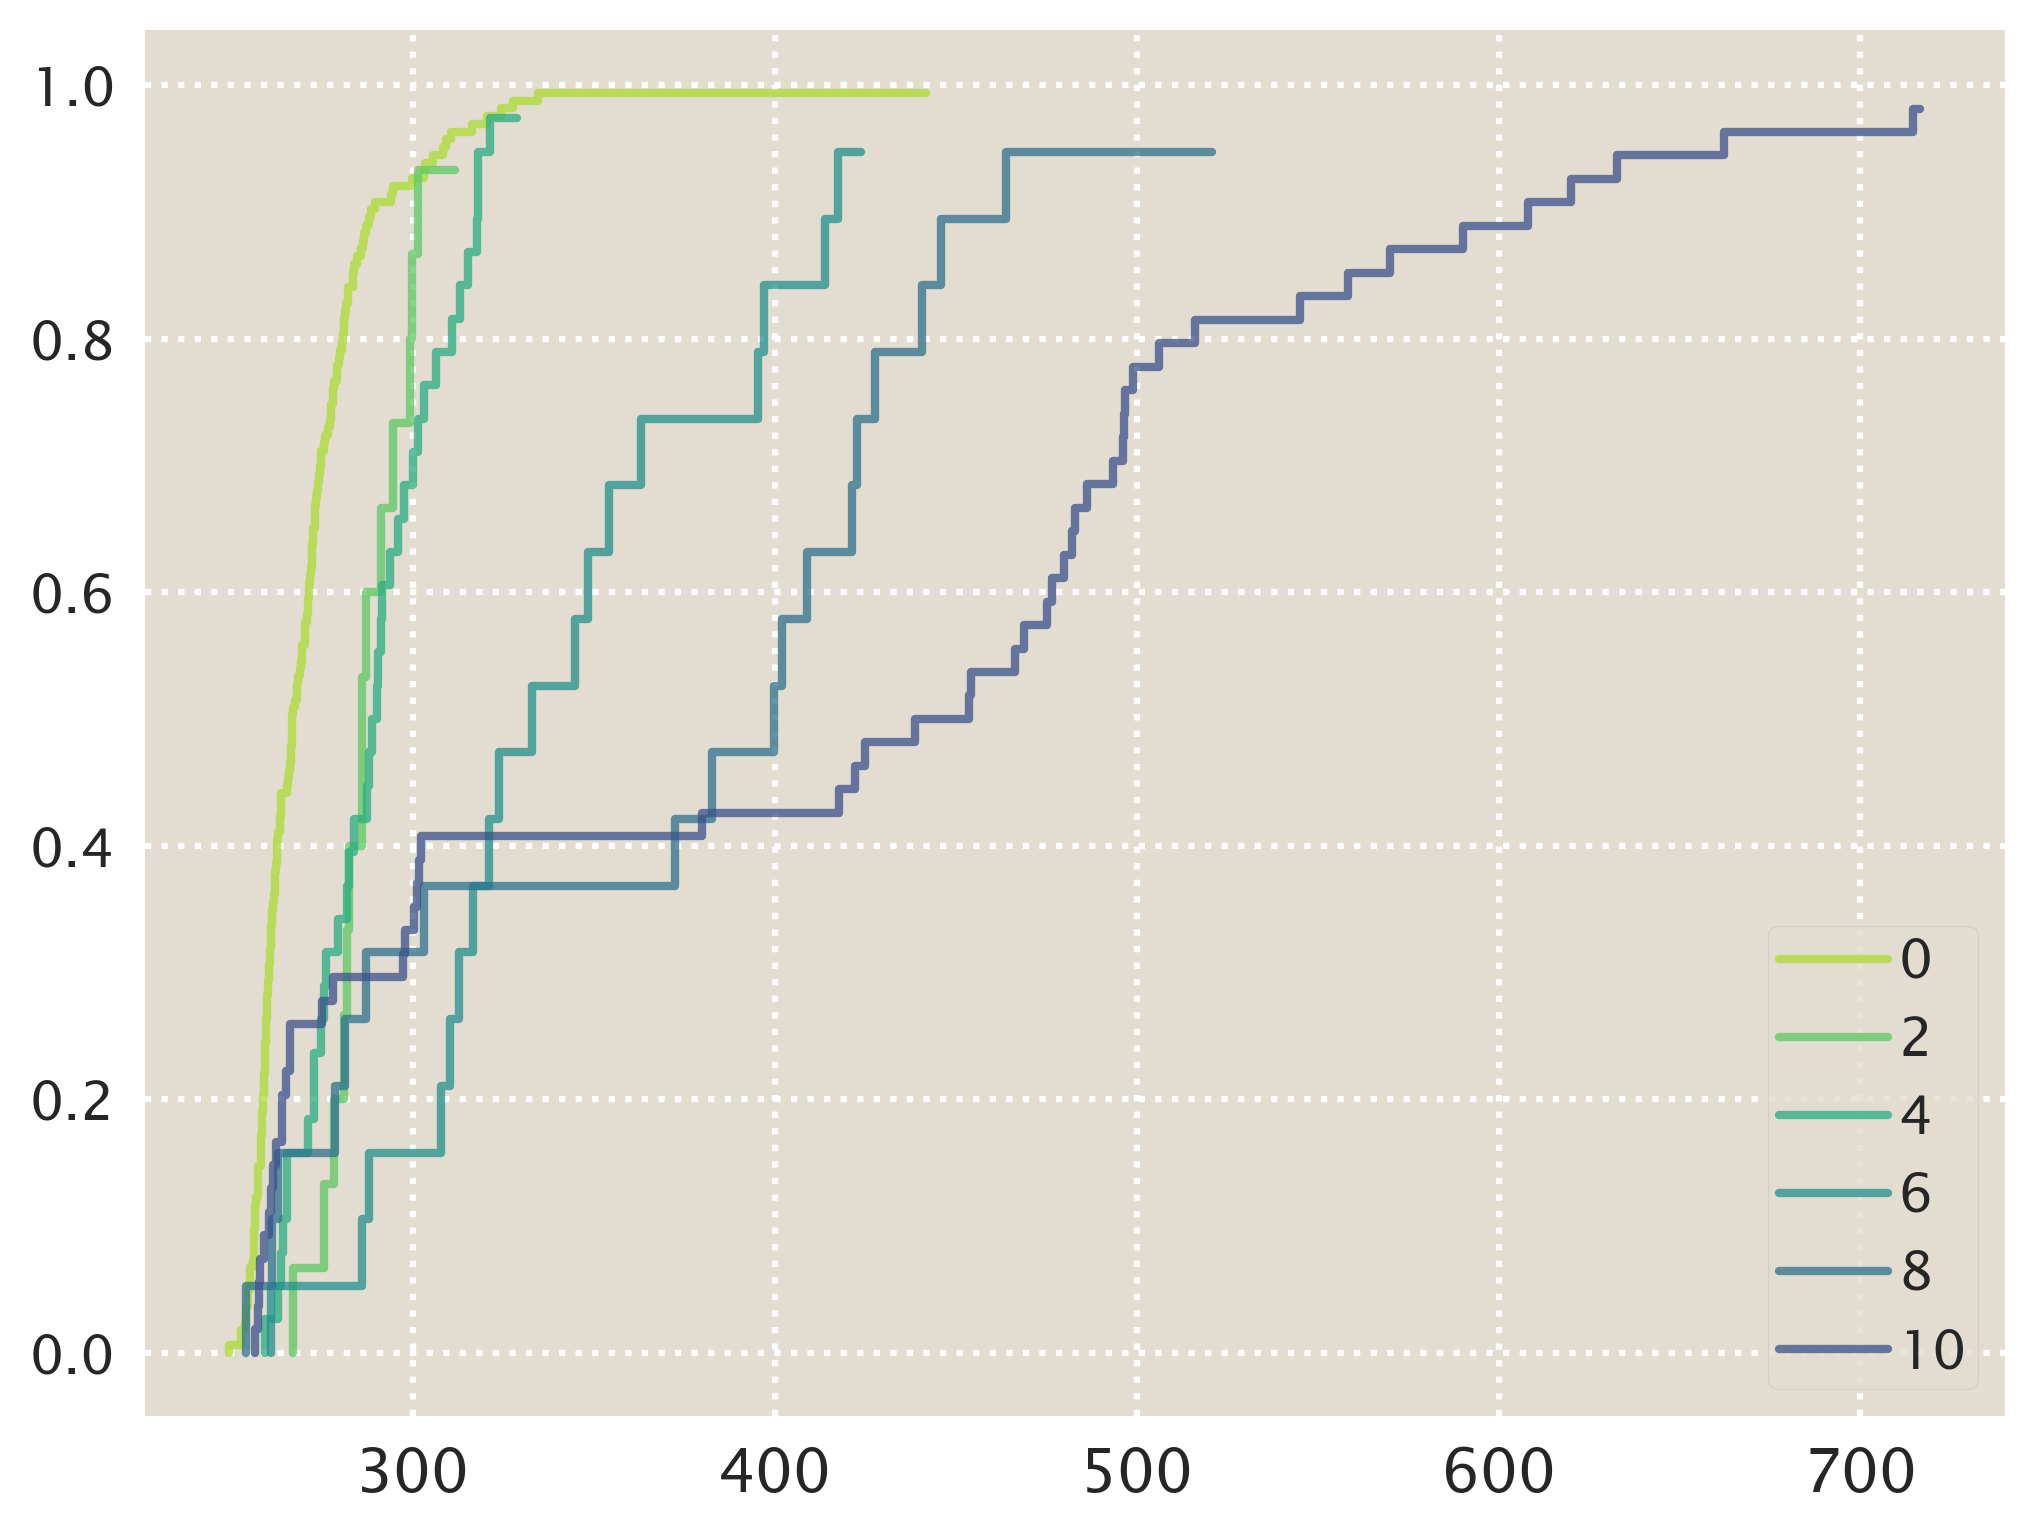

In [76]:
grouped = df.groupby(['atc_ngml'])
colors = sns.color_palette('viridis_r', n_colors=len(concs))
def ecdf(data):
    return np.sort(data), np.arange(len(data)) / len(data)

plt.figure()
i = 0
for g, d in grouped: 
    x, y =  ecdf(d['mean_mcherry'])
    plt.step(x, y, '-', color=colors[i], label=g, alpha=0.75)

    i+=1
plt.legend() 
# plt.xscale('log')

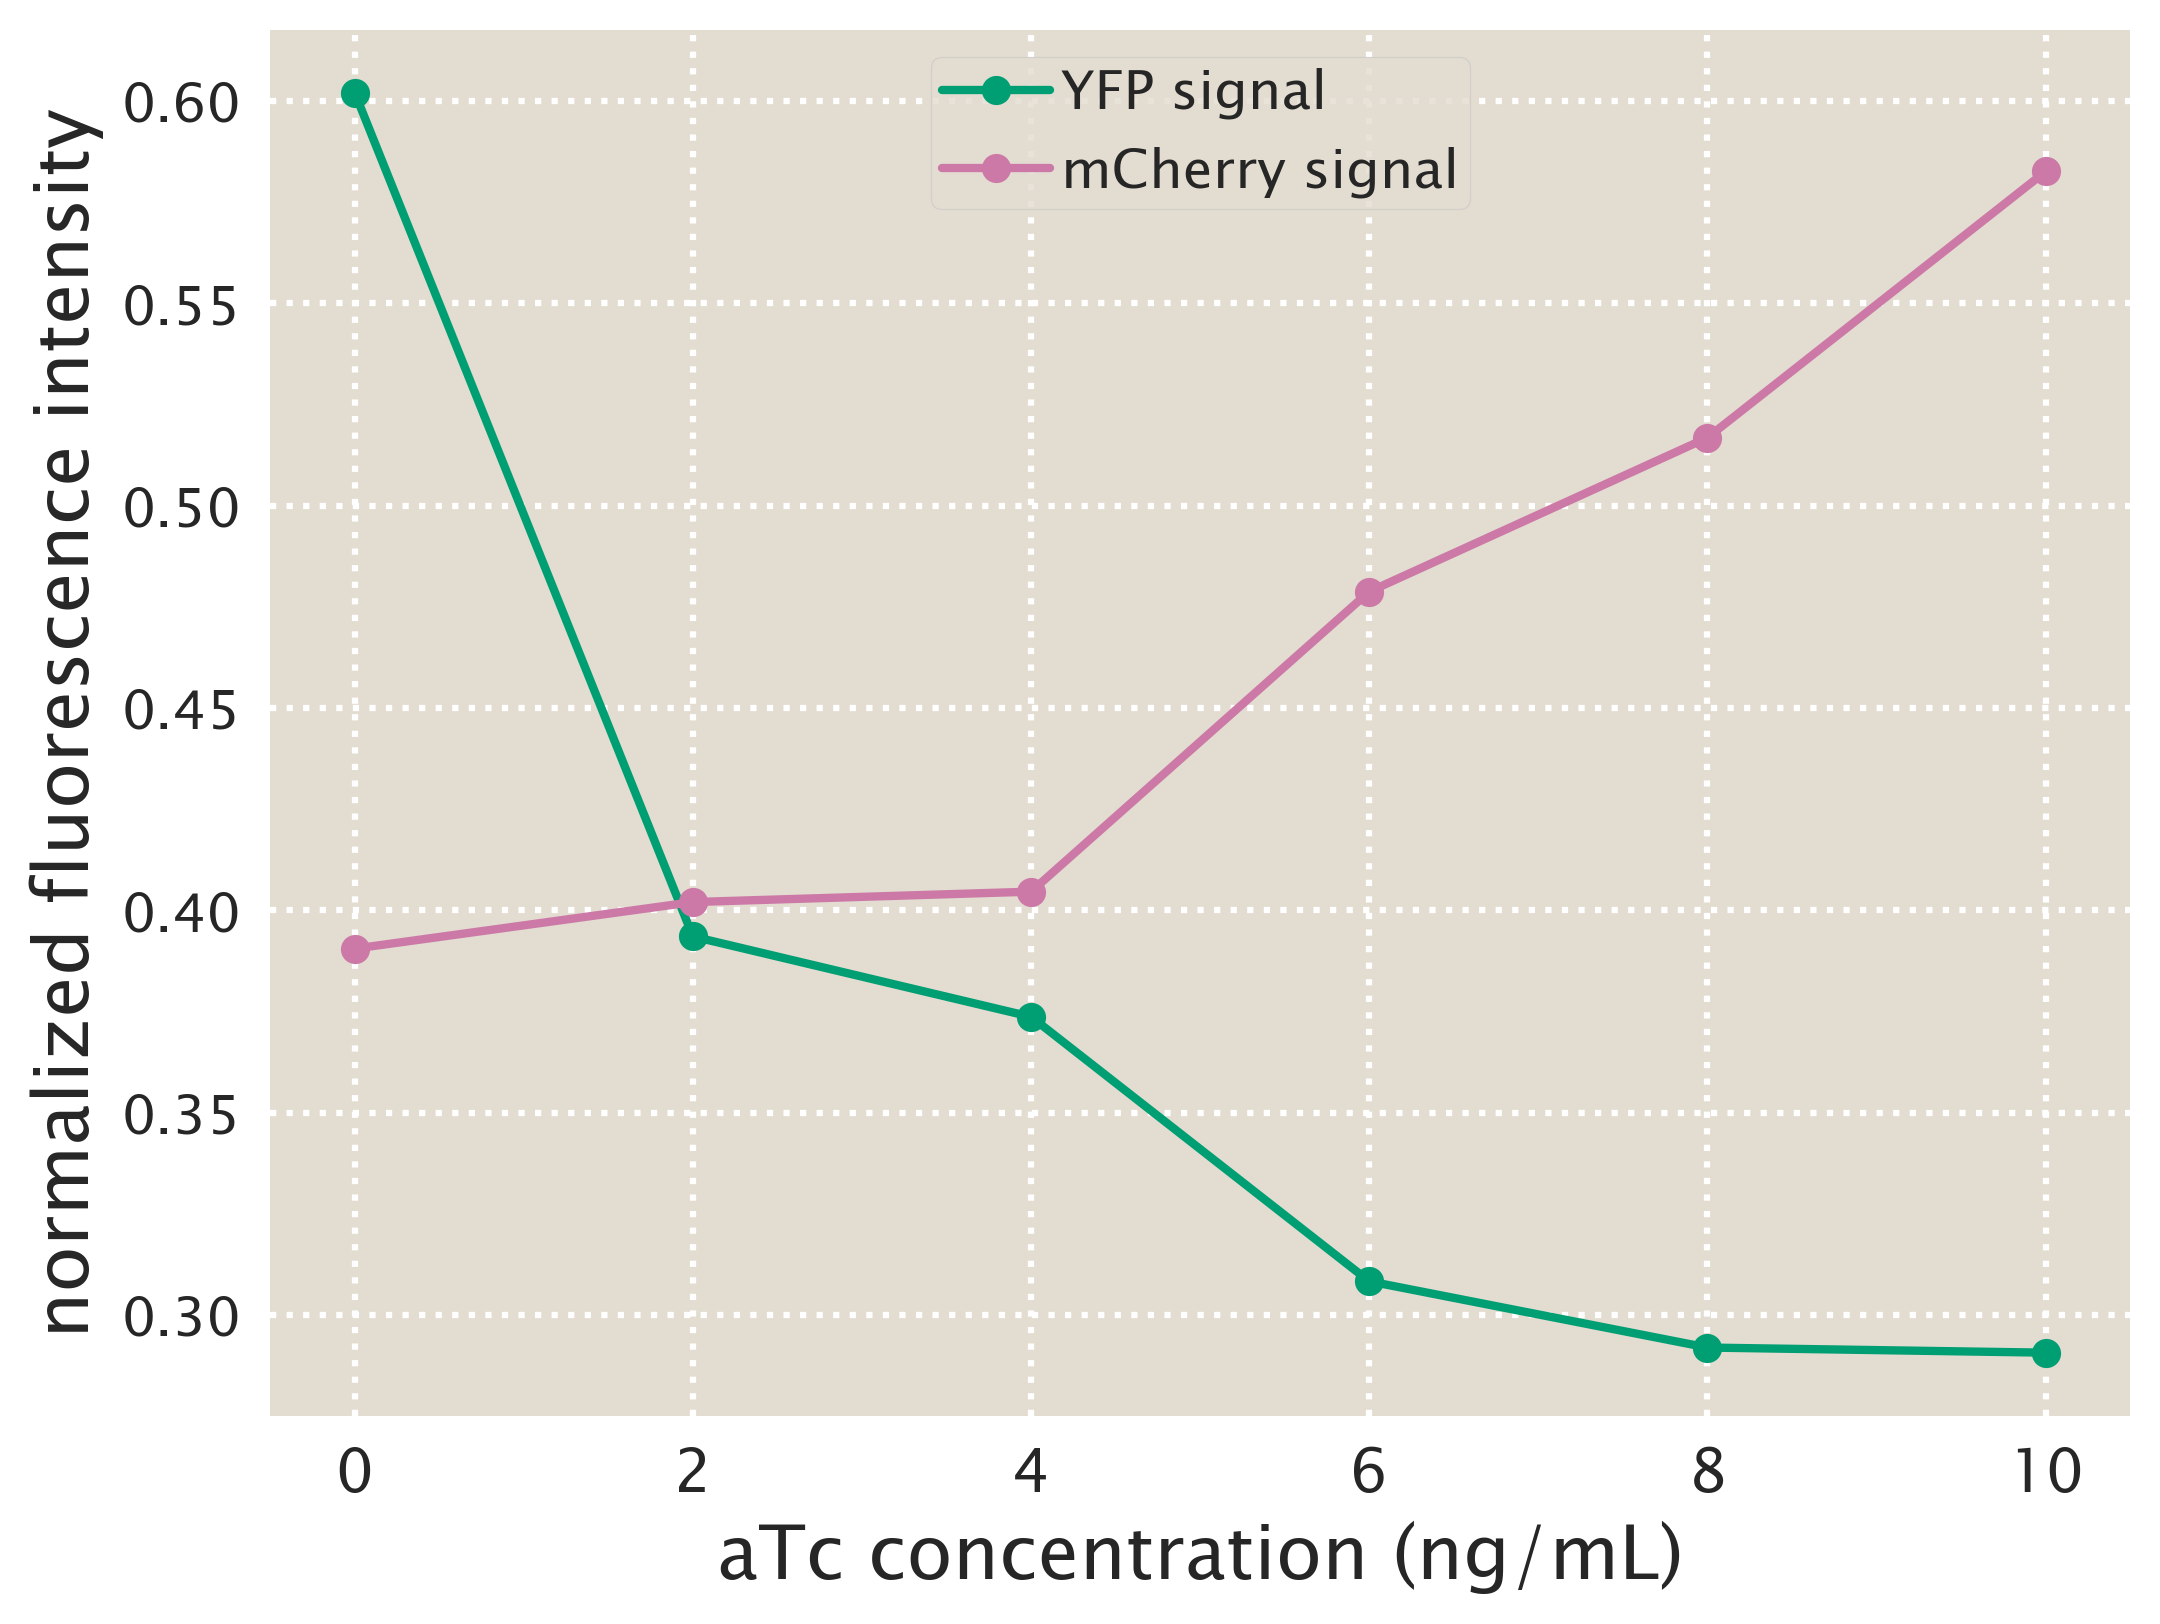

In [82]:
# plot the 'normalized' fluorescence change of each. 
slice_df = df.copy()
slice_df['norm_mcherry'] = slice_df['mean_mcherry'] / slice_df['mean_mcherry'].max()
slice_df['norm_yfp'] = slice_df['mean_yfp'] / slice_df['mean_yfp'].max()
slice_df = slice_df[(slice_df['strain'] != 'auto') & (slice_df['strain'] != 'delta')]
slice_grouped = pd.DataFrame(slice_df.groupby('atc_ngml').mean()).reset_index()
plt.figure()
plt.plot(slice_grouped['atc_ngml'], slice_grouped['norm_yfp'], 'g-o', label='YFP signal')
plt.plot(slice_grouped['atc_ngml'], slice_grouped['norm_mcherry'], 'm-o', label='mCherry signal')
plt.legend(loc='upper center')
plt.xlabel('aTc concentration (ng/mL)')
plt.ylabel('normalized fluorescence intensity')
plt.savefig('atc_v_fluorescence_microscopy.pdf')

20170810
20170814


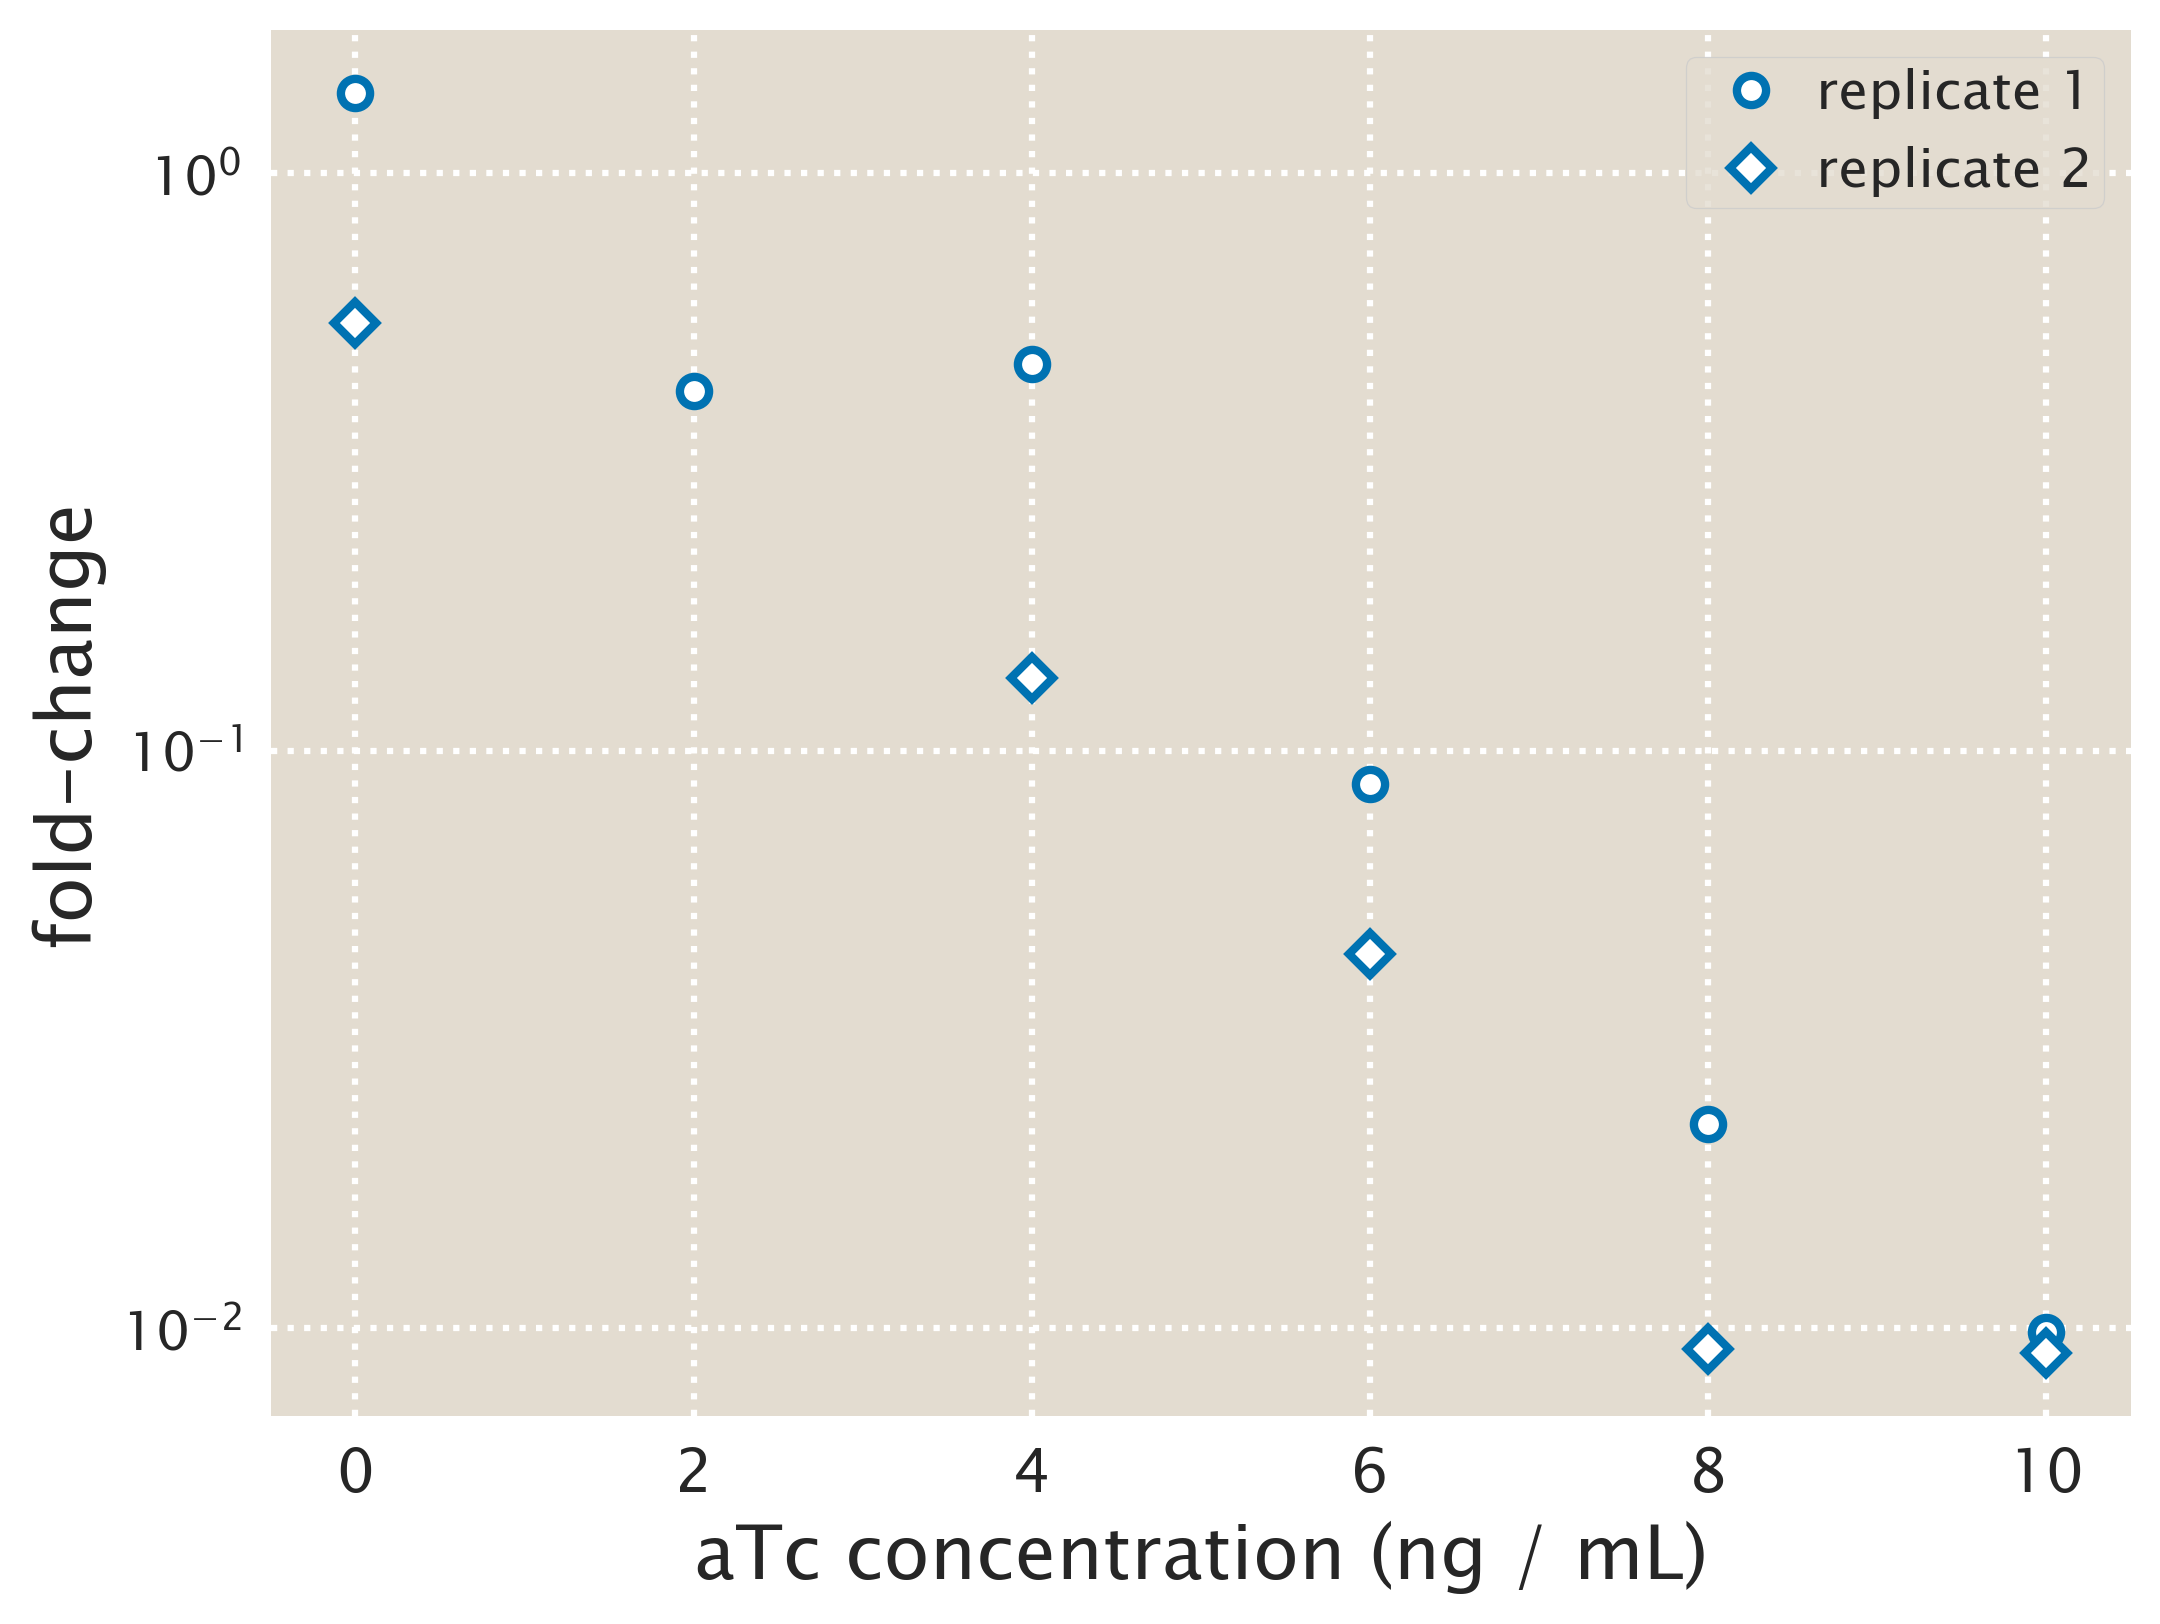

In [74]:
grouped = df.groupby(['date'])
i = 1
for  g, d in grouped:
    print(g)
    _grouped = pd.DataFrame(d.groupby(['atc_ngml', 'strain']).mean()).reset_index()
    auto_val = _grouped[_grouped['strain'] == 'auto']['mean_yfp'].mean()
    delta_val = _grouped[_grouped['strain']=='delta']['mean_yfp'].mean()
    _grouped['fc'] = (_grouped['mean_yfp'] - auto_val) / (delta_val - auto_val)
    _grouped = _grouped[(_grouped['strain'] != 'auto') & (_grouped['strain'] != 'delta')]
    if g == '20170810': 
        marker='o'
    else:
        marker = 'D'
    plt.plot(_grouped['atc_ngml'], _grouped['fc'], linestyle='none', marker=marker,\
             markerfacecolor='w',  markeredgecolor='b',\
             markeredgewidth=2, label='replicate {0}'.format(i))
    i += 1
plt.legend() 
plt.xlabel('aTc concentration (ng / mL)')
plt.ylabel('fold-change')
plt.yscale('log')
plt.savefig('fc_vs_atc.pdf', bbox_inches='tight')
plt.ylabel()